<a href="https://colab.research.google.com/github/NicholasLeotta99/Neuromatch_BrainCancer/blob/Nick/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
#from torchsummary import summary

import os
#from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)
if torch.cuda.is_available():
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


In [2]:
# @title Data Loading
if os.path.isdir('./Training'):
    !rm ./Training/ -d -r
    !rm ./Testing/ -d -r
    !rm ./Validation/ -d -r
try:
    from google.colab import files
    if not os.path.isfile('./.kaggle/kaggle.json'):
        print('Upload kaggle.json account information to download the dataset:')
        files.upload()
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 /root/.kaggle/kaggle.json
except:
    print('Colab initialization failed')
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --force
!unzip -q brain-tumor-mri-dataset.zip 

Colab initialization failed
 98%|███████████████████████████████████████ | 145M/149M [00:03<00:00, 40.1MB/s]
100%|████████████████████████████████████████| 149M/149M [00:03<00:00, 41.4MB/s]


In [3]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
  os.mkdir('./Validation/')
  classes = os.listdir('./Training/')
  training_samples = []
  for i in classes:
    os.mkdir(f'./Validation/{i}/')
    files = os.listdir(f'./Training/{i}/')
    for f in files:
      training_samples.append(f'/{i}/{f}')
  random.shuffle(training_samples)
  validation_samples = training_samples[0:1100]
  training_samples = training_samples[1100:]
  for samp in validation_samples:
    os.rename(f'./Training{samp}', f'./Validation{samp}')


In [4]:
# @title Loading Model
Classifier = models.vgg19(weights='DEFAULT')
#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)
Classifier.to('cuda')
#summary(Classifier, (3, 256, 256))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

0 tensor([3, 3, 2, 1, 0, 3, 2, 0, 0, 0, 2, 2, 1, 2, 1, 0])
torch.Size([16, 3, 256, 256])


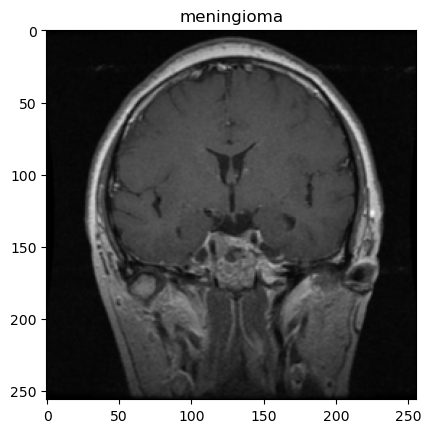

In [5]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])

TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=16, shuffle=True)

ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size=16, shuffle=True)

TestDataset = ImageFolder(root='./Testing/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TestLoader = DataLoader(TestDataset, batch_size=16, shuffle=True)

classes = os.listdir('./Training/')
for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  print(images.shape)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [6]:
#train_plot(loss, acc, val_loss, val_acc) 
#len(TrainingLoader.dataset)

Adding 10 iterations to model training


/home/nicholas/anaconda3/envs/Neuro/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Trained 1 epochs
Trained 2 epochs
Trained 3 epochs
Trained 4 epochs
Trained 5 epochs
Trained 6 epochs
Trained 7 epochs
Trained 8 epochs
Trained 9 epochs
Trained 10 epochs


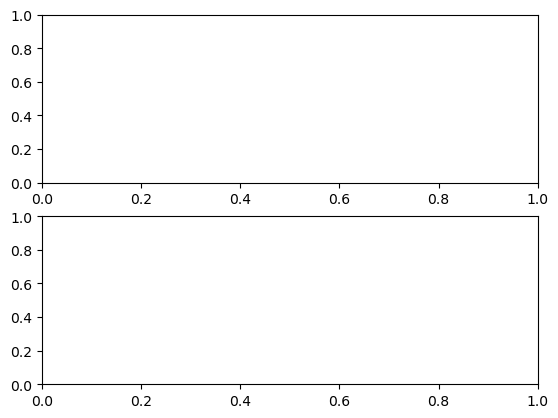

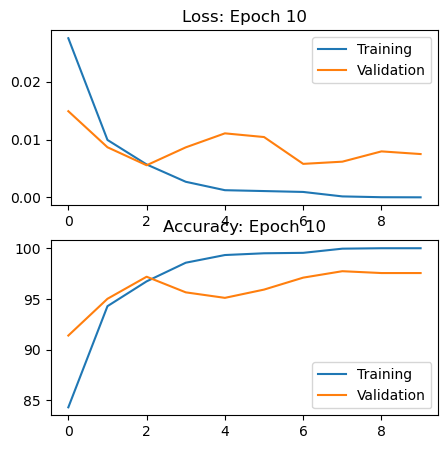

In [8]:
class Brain_Classifier():
    # Class to assist with training and evaluation of our Brain Tumor Classification model
    
    def __init__(self, model, train_dir='./Training', val_dir='./Validation', test_dir='./Testing'):
        self.Model = model
        

        self.build_loader(train_dir, val_dir, test_dir)
        
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.Model.parameters(), lr=0.005, momentum=.5)
        
        self.trained_epochs = 0
        self.display, self.ax = plt.subplots(2,1)

    def build_loader(self, train_dir, val_dir, test_dir):
        #Build the data loaders for training and evaluation
        data_transf = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])
        self.TrainData = DataLoader(ImageFolder(root=train_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        self.ValData = DataLoader(ImageFolder(root=val_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        self.TestData = DataLoader(ImageFolder(root=test_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        
    def run_epoch(self, train=False, data='validation'):
        if data == 'train': dataset = self.TrainData
        elif data == 'validation': dataset = self.ValData
                
        current_loss = 0
        batch_accuracy = 0
        for i, j in enumerate(dataset):
            if train: self.optimizer.zero_grad()
                
            inputs, labels = j
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            
            outputs = self.Model(inputs)
            loss = self.loss_fn(outputs, labels)
            if train: loss.backward(), self.optimizer.step()
            
            current_loss += loss.item()
            batch_accuracy += self.accuracy(outputs, labels)

        return (current_loss / len(dataset.dataset)), (batch_accuracy / (i+1))
    
    def train(self, n_epochs):
        print(f'Adding {n_epochs} iterations to model training')
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []

        for i in range(0, n_epochs):
            loss, acc = self.run_epoch(train=True, data='train')
            self.train_loss.append(loss)
            self.train_acc.append(acc)
            
            loss, acc = self.run_epoch(train=False, data='validation')
            self.val_loss.append(loss)
            self.val_acc.append(acc)
            
            self.trained_epochs += 1
            print(f'Trained {self.trained_epochs} epochs')
        self.plot_status()

    def accuracy(self, prediction, label):
        prediction = torch.argmax(prediction, axis=1)
        return ((prediction == label).sum()/len(label) * 100).cpu()

    def plot_status(self):
        plt.figure(figsize=(5,5))
        plt.subplot(2,1,1)
        plt.plot(self.train_loss, label='Training')
        plt.plot(self.val_loss, label='Validation')
        plt.title(f'Loss: Epoch {self.trained_epochs}')
        plt.legend()
        
        plt.subplot(2,1,2)
        plt.plot(self.train_acc, label='Training')
        plt.plot(self.val_acc, label='Validation')
        plt.title(f'Accuracy: Epoch {self.trained_epochs}')
        plt.legend()
        plt.draw()

    
A = Brain_Classifier(Classifier)
A.train(10)

In [ ]:
print(A.train_acc)